## Import

In [1]:
import os
import struct
import tensorflow as tf

In [2]:
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.unit8).reshape(
                             len(labels), 784)
        images = ((images / 255) - .5) * 2
        
    return images, labels

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [5]:
print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


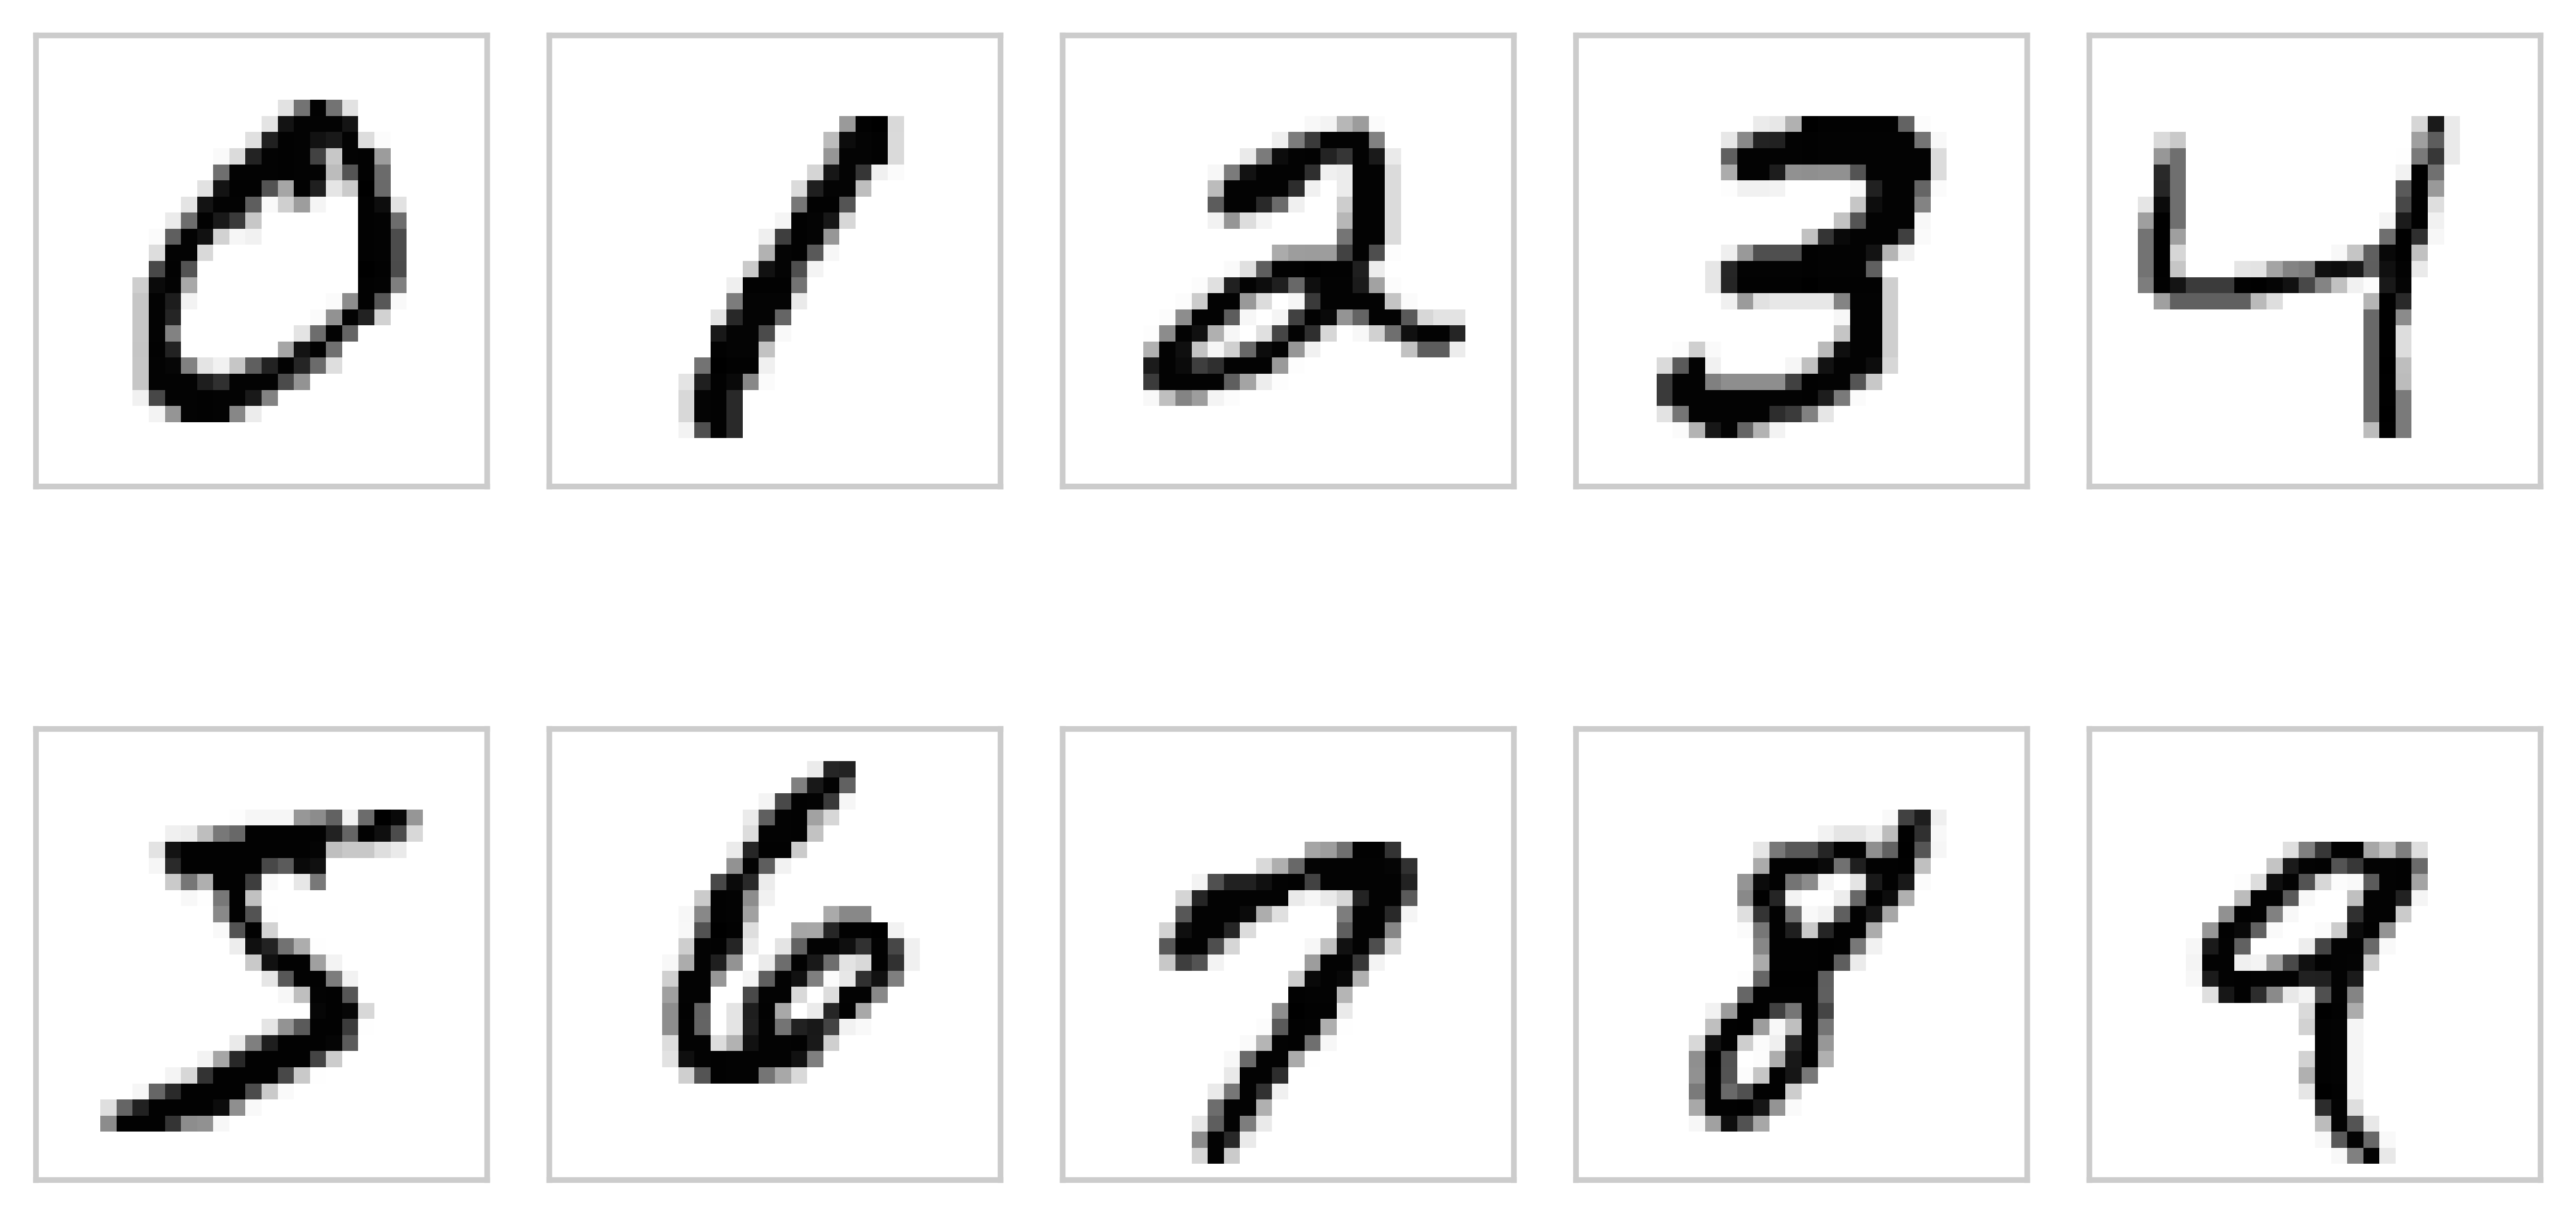

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=5, 
                       sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

#### Numpy 다차원 배열 형식으로 저장하기

In [7]:
np.savez_compressed('mnist_scaled.npz',
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [8]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [9]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

## Preprocessing

#### Standardization

In [10]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

In [11]:
X_train_centered = (X_train - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val

In [12]:
del X_train, X_test

In [13]:
print(X_train_centered.shape, X_test_centered.shape)

(60000, 784) (10000, 784)


#### One-hot encode target

In [14]:
np.random.seed(42)

In [15]:
y_train_onehot = tf.keras.utils.to_categorical(y_train)
print("처음 5개의 레이블:", y_train[:5])
print("처음 5개의 one-hot 레이블:\n", y_train_onehot[:5])

처음 5개의 레이블: [5 0 4 1 9]
처음 5개의 one-hot 레이블:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Feed-forward Neural Network

In [16]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=256,
        input_dim=X_train_centered.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='relu'))

model.add(
    tf.keras.layers.Dense(
        units=64,
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='relu'))

model.add(
    tf.keras.layers.Dense(
        units=y_train_onehot.shape[1],
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


In [18]:
sgd_optimizer = tf.keras.optimizers.SGD(
    lr=0.001, decay=1e-7, momentum=.9)

In [19]:
model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy')

In [20]:
history = model.fit(X_train_centered, y_train_onehot,
                    batch_size=64, epochs=50,
                    verbose=1,
                    validation_split=0.1)

W0916 23:42:02.937768 4549555648 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 24us/sample - loss: 0.5364 - val_loss: 0.2119
Epoch 2/50
54000/54000 [==============================] - 1s 21us/sample - loss: 0.2241 - val_loss: 0.1591
Epoch 3/50
54000/54000 [==============================] - 1s 23us/sample - loss: 0.1725 - val_loss: 0.1324
Epoch 4/50
54000/54000 [==============================] - 1s 22us/sample - loss: 0.1430 - val_loss: 0.1192
Epoch 5/50
54000/54000 [==============================] - 1s 21us/sample - loss: 0.1228 - val_loss: 0.1098
Epoch 6/50
54000/54000 [==============================] - 1s 20us/sample - loss: 0.1075 - val_loss: 0.1032
Epoch 7/50
54000/54000 [==============================] - 1s 22us/sample - loss: 0.0957 - val_loss: 0.0955
Epoch 8/50
54000/54000 [==============================] - 1s 21us/sample - loss: 0.0857 - val_loss: 0.0920
Epoch 9/50
54000/54000 [==============================] - 1s 21us/sample - loss: 0.0772 - val_l

In [21]:
y_train_pred = model.predict_classes(X_train_centered,
                                     verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]
print("훈련 정확도: %.2f%%" % (train_acc * 100))

y_test_pred = model.predict_classes(X_test_centered,
                                     verbose=0)
correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]
print("테스트 정확도: %.2f%%" % (test_acc * 100))

훈련 정확도: 99.79%
테스트 정확도: 97.62%
